---
# 0. Preparing environment

### 0.1 Importing modules

In [6]:
# Uncoment to install packages
# !pip install pmdarima
# !pip install tbats

import os
import pandas as pd 
import numpy as np; np.random.seed(25486)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import clear_output as co
import warnings; warnings.filterwarnings('ignore')
import pickle
import json
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.utils

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima
from tbats import TBATS

import tools # Custom module

### 0.2 Defining metrics to evaluate predictive models

In [7]:
le = sklearn.preprocessing.LabelEncoder
metrics = sklearn.metrics._regression
mae = metrics.mean_absolute_error
mse = metrics.mean_squared_error
mape = metrics.mean_absolute_percentage_error
r2 = metrics.r2_score
me = metrics.max_error
medae = metrics.median_absolute_error
evs = metrics.explained_variance_score
mpd = metrics.mean_poisson_deviance
mgd = metrics.mean_gamma_deviance

def wape(ye, yhat):
    return np.abs(ye-yhat).sum()/ye.sum()
def e(ye, yhat):
    return np.abs(yhat-ye).sum()
def estd(ye, yhat):
    return np.abs(yhat-ye).std()

### 0.3 Defining functions

In [8]:
def get_lab_series(series, data, target='area', index_col='year', n_min=3):
    LE = le().fit(data[index_col])
    lab_series = {}
    for key in series.keys():
        if len(series[key])>=n_min:
            lab_series[key] = pd.Series(series[key][target].values, index=LE.transform(series[key][index_col]))
    return lab_series

def get_lab_indexed_series(series, data, cols=['index', 'area'], index_col='year', n_min=3):
    LE = le().fit(data[index_col])
    lab_ind_series = {}
    for key in series.keys():
        if len(series[key])>=n_min:
            lab_ind_series[key] = pd.DataFrame(series[key].reset_index()[cols].values, columns=cols, index=LE.transform(series[key][index_col]))
    return lab_ind_series

class scoring:
    def __init__(self, scorers, criteria_map):
        self.scorers = scorers
        self.criteria_map = criteria_map
    def score(self, ye, yhat, metrics=['mae', 'mse', 'mape', 'wape', 'r2'], model_name='Predictive Model'):
        return pd.Series([self.scorers[metric](ye, yhat) for metric in metrics], index=metrics, name=model_name)    
    def score_by_product(self, ye, yhat, indexes, metrics=['mae', 'mse', 'mape', 'wape', 'r2'], model_name='Predictive Model'):
        prod_scrs = []
        for product in indexes.keys():
            prod_index = indexes[product]
            test_index = set(prod_index).intersection(yhat.index)
            if len(test_index):
                Ye, Yhat = ye.loc[test_index], yhat.loc[test_index]
                scrs = self.score(Ye, Yhat, metrics, model_name=product)
            else:
                scrs = pd.Series([np.nan]*len(metrics), index=metrics, name=product)
            prod_scrs.append(scrs)
        prod_scrs_df = pd.concat(prod_scrs, 1)
        prod_scrs_df.index.name = model_name
        return prod_scrs_df

def split_serie(serie, train_size, test_size):
    train = serie.iloc[:train_size]
    test = serie.iloc[train_size : train_size+test_size]
    xt, yt = train.index.values.reshape(-1, 1), train.values
    xe, ye = test.index.values.reshape(-1, 1), test.values
    return xt, yt, xe, ye

def fit_predict(model, xt, yt, xe):
    model_fit = model().fit(xt, yt)
    return model_fit.predict(xe)

def predict_by_model_name(model, model_name, xt, yt, xe, specialized_models):
    x_min = len(yt)
    x_max = x_min+len(xe)-1
    if model_name not in specialized_models:
        return fit_predict(model, xt, yt, xe)
    elif model_name=='AutoReg':
        return AutoReg_predict(yt, x_min, x_max)
    elif model_name=='ARIMA':
        return predict_arima(yt, x_min, x_max)
    elif model_name=='SARIMAX':
        return predict_SARIMAX(yt, x_min, x_max)
    elif model_name=='AutoArima':
        return predict_auto_arima(yt, x_min, x_max)
    elif model_name=='TBATS':
        return predict_tbats(yt, x_min, x_max)
    
def score_model_for_serie(model, serie, train_size, test_size, metrics, model_name, specialized_models):
    xt, yt, xe, ye = split_serie(serie, train_size, test_size)
#     yhat = fit_predict(model, xt, yt, xe)
    yhat = predict_by_model_name(model, model_name, xt, yt, xe, specialized_models)
    if yhat is None:
        return None
    else:
        return Scoring.score(ye, yhat, metrics, model_name)

def learning_curve(
    model, serie, test_size=2, min_train_size=1,
    metrics=['mae', 'mse', 'mape', 'wape', 'r2'],
    model_name='Predictive Model',
    specialized_models=['AutoReg', 'ARIMA', 'SARIMAX', 'AutoArima']
):
    scores = []
    n = len(serie)
    train_size_i = range(min_train_size, n-test_size+1)
    for train_size in train_size_i:
        score = score_model_for_serie(model, serie, train_size, test_size, metrics, model_name, specialized_models)
        if score is None:
            score = pd.Series([np.nan]*len(metrics), index=metrics, name=model_name)
        scores.append(score)
    scores_df = pd.concat(scores, 1).T
    scores_df.index = train_size_i
    scores_df.columns.name = model_name
    scores_df.index.name = 'train size'
    return scores_df

def plot_learning_curves(lc):
    ax = plt.figure(figsize=(5, 3*lc.shape[1]), tight_layout=True).add_subplot()
    lc.plot(subplots=True, ax=ax)
    plt.show()

# Calculates learning curve scores averages by provided method
def average_lc(lc_df,  avg_method='simple', min_train_size=1, weight_order=1):
    if avg_method=='simple':
        avg_lc = lc_df.mean()
    elif avg_method=='min_train_size':
        avg_lc = lc_df.loc[min_train_size:].mean()
    elif avg_method=='weighted':
        n = len(lc_df)
        weights = np.linspace(1/n, 1, n)**weight_order
        avg_lc = lc_df.T.dot(weights)/sum(weights)
    elif avg_method=='train_size_weighted':
        weights = lc_df.index.values**weight_order
        avg_lc = lc_df.T.dot(weights)/sum(weights)
    avg_lc.name = lc_df.columns.name
    return avg_lc

def models_lc(
    models_names, regressors, serie, test_size=2, min_train_size=1,
    metrics=['mae', 'mse', 'mape', 'wape', 'r2'],
    avg_method='simple', avg_min_train_size=1, weight_order=1, verbose=1,
    specialized_models=['AutoReg', 'ARIMA', 'SARIMAX', 'AutoArima'],
    spec_min_train_size = {'AutoReg': 3 , 'ARIMA': 2, 'SARIMAX': 2, 'AutoArima': 3,  'TBATS': 0}
):
    default_min_train_size = min_train_size + 0
    avg_lc_i = []
    n_models = len(models_names)
    for i, model_name in enumerate(models_names):
        if model_name in specialized_models:
            if (len(serie) - test_size) <= spec_min_train_size[model_name]:
                continue
            else:
                min_train_size = spec_min_train_size[model_name] + 1
            model = None
        else:
            min_train_size = default_min_train_size
            model = regressors[model_name]
        lc_df = learning_curve(model, serie, test_size, min_train_size, metrics, model_name, specialized_models)
        avg_lc_i.append(average_lc(lc_df, avg_method, avg_min_train_size, weight_order))
        if verbose: co(wait=True); print(f'Models scored: {i+1}/{n_models}')
    return pd.concat(avg_lc_i, 1)

def select_keys_models(
    models_names, regressors, series, keys,
    criteria, test_size=2, min_train_size=1,
    metrics=['mae', 'mse', 'mape', 'wape', 'r2'],
    avg_method='simple', avg_min_train_size=1,
    weight_order=1, verbose=0, save=True,
    path='models/key_model_maps/{}.json', filename='key_model_map_default',
    specialized_models=['AutoReg', 'ARIMA', 'SARIMAX', 'AutoArima'],
    spec_min_train_size = {'AutoReg': 3, 'ARIMA': 2, 'SARIMAX': 2, 'AutoArima': 3,  'TBATS': 0}
):
    keys_models = {}
    keys_models_scrs = {}
    for i, key in enumerate(keys):
        serie = series[key].copy()
        if len(serie) < (min_train_size + test_size): continue
        key_models_lc = models_lc(
            models_names, regressors, serie, test_size, min_train_size,
            metrics, avg_method, avg_min_train_size, weight_order,
            0, specialized_models, spec_min_train_size
        )
        top_model_name = key_models_lc.loc[[criteria]].T.sort_values(criteria).iloc[Scoring.criteria_map[criteria]].name
        keys_models[key] = top_model_name
        keys_models_scrs[key] = key_models_lc
        if verbose: co(wait=True); print(f"Keys scored: {i+1}/{len(keys)}")
    #### Saving key-model map
    if save:
        json.dump(keys_models, open(path.format(filename), 'w'))
    return keys_models, keys_models_scrs

def predict_custom_model_test_sequences(
    series, keys_models, keys, n=44, test_size=2,
    min_train_size=1, min_test_size=1, dropna=True,
    specialized_models=['AutoReg', 'ARIMA', 'SARIMAX', 'AutoArima', 'VAR', 'TBATS'],
    out_names = ['VAR', 'TBATS'],
    old_names_dict = {'Yhat_AutoReg': 'AutoReg', 'Yhat_arima': 'ARIMA', 'Yhat_sarimax': 'SARIMAX', 'Yhat_var': 'VAR', 'Yhat_autoarima': 'AutoArima', 'Yhat_tbats': 'TBATS'}
):
    train_last_i = range(0, n-test_size)
    yhat_i = {train_last+1: [] for train_last in train_last_i}
    for i, key in enumerate(keys):
        co(wait=True); print(f'Keys predicted: {i}/{len(keys)}')
        model_name = keys_models[key]
        serie = series[key].copy()
        if model_name in list(old_names_dict.keys()): model_name = old_names_dict[model_name]
        if model_name in specialized_models:
            model = None
            if model_name in out_names: model_name = 'ARIMA'
        else:
            model = regressors[model_name]
        for train_last in train_last_i:
            test_min = train_last+1
            test_max = train_last+test_size                
            train = serie.loc[:train_last]
            test = serie.loc[test_min:test_max]
            xe = np.array(range(test_min, test_max+1)).reshape(-1, 1)
            true_index = [(test.loc[index]['index'] if index in test.index else np.nan) for index in xe.reshape(-1)]
            empty_scrs = pd.Series([np.nan]*test_size, index=true_index)
            if len(train) >= min_train_size and len(test) >= min_test_size:
                xt, yt = train.index.values.reshape(-1, 1), train[target].values
#                 yhat = model.fit(xt, yt).predict(xe)
                yhat = predict_by_model_name(model, model_name, xt, yt, xe, specialized_models)
                if yhat is None:
                    yhat_i[train_last+1].append(empty_scrs)
                else:
                    yhat_i[train_last+1].append(pd.Series(yhat, index=true_index))
            else:
                yhat_i[train_last+1].append(empty_scrs)
    for key in yhat_i.keys():
        yhat_i[key] = pd.concat(yhat_i[key])
        if dropna: yhat_i[key].dropna(inplace=True)
    return yhat_i

def score_indexed_prediction_by_product(
    yhat, data, target, indexes, criteria='wape', avg=True,
    metrics=['mae', 'estd', 'max_error', 'mse', 'wape', 'r2'],
    model_name='Custom predictive model'
):
    test_index = set(yhat.dropna().index).intersection(data.dropna(subset=[target]).index)
    Yhat = yhat.loc[test_index].copy()
    Ye = data[target].loc[test_index].copy()
    prod_scrs = Scoring.score_by_product(Yhat, Ye, indexes, metrics, model_name).loc[criteria]
    prod_scrs.name = model_name
    if avg: prod_scrs = prod_scrs.mean()
    return prod_scrs

def score_prediction_sequences(
    yhat_i, data, indexes, target='area',
    n=44, test_size=2, eval_criteria='wape', avg=False,
    metrics=['mae', 'estd', 'max_error', 'mse', 'wape', 'r2']
):
    train_last_scrs = []
    train_last_i = range(1, n-test_size+1)
    for train_last in train_last_i:
        yhat = yhat_i[train_last].copy()
        train_last_scrs.append(score_indexed_prediction_by_product(
            yhat, data, target, indexes, eval_criteria, avg,
            metrics, train_last
        ))
    yhat_i_scrs = pd.DataFrame(train_last_scrs)
    yhat_i_scrs.index.name = 'train last'
    yhat_i_scrs.columns.name = eval_criteria
    return yhat_i_scrs

def weight_average(df, order):
    matrix = df.dropna()
    n_samples = len(matrix)
    weights = np.linspace(1/n_samples, 1, n_samples)**order
    return matrix.T.dot(weights)/sum(weights)

def model_selection_params_optimization(
    models_names, regressors, params_dict, 
    lab_series, keys, verbose=0, save=True,
    path='models/key_model_maps/{}.json'
):
    if verbose: print('MODEL SELECTION PARAMS OPTIMIZATION'); print()
    key_model_maps_dict = {}
    key_model_maps_scrs = {}
    for i, params_key in enumerate(params_dict.keys()):
        if verbose: print(f'Evaluating parameters: {params_key} {i+1}/{len(params_dict)}')
        key_model_maps_dict[params_key], key_model_maps_scrs[params_key] = select_keys_models(
            models_names, regressors, lab_series, keys,
            **params_dict[params_key], verbose=0, save=save,
            path=path, filename=params_key
        )
    if verbose: co(wait=True); print(f'Done! Saved {len(params_dict)} key-model maps.')
    return key_model_maps_dict, key_model_maps_scrs

#### Loading key-model maps
def load_key_model_maps(path='models/'):
    maps_filenames = os.listdir(path)
    maps = {}
    for filename in maps_filenames:
        if '.json' in filename:
            maps[filename.split('.')[0]] = json.load(open(path+filename, 'r'))
    maps_keys = list(maps.keys())
    return maps, maps_keys

#### Predicting with key-model map custom models
def maps_predictions(
    lab_ind_series, n, test_size, min_train_size,
    min_test_size, dropna, path='models/key_model_maps/', save=True, # change 'min_test_size' to zero and 'dropna' to False to predict non-included test_samples (when n > n_max)
    save_path='evaluation/scores/custom models/'
):
    maps, maps_keys = load_key_model_maps(path)
    map_models_predictions = {}
    for map_key in maps_keys:
        map_model = maps[map_key]
        sel_keys = list(map_model.keys())
        y_hat_i = predict_custom_model_test_sequences(
            lab_ind_series, map_model, sel_keys,
            n, test_size, min_train_size,
            min_test_size, dropna # change 'min_test_size' to zero and 'dropna' to False to predict non-included test_samples (when n > n_max)
        )
        if save:
            folder_path = f'{save_path}{map_key}/'
            if map_key not in os.listdir(save_path):
                os.mkdir(folder_path)
            for key in y_hat_i.keys():
                y_hat_i[key].to_csv(folder_path + f'{key}.csv', index=True)
        map_models_predictions[map_key] = y_hat_i
    return map_models_predictions

def load_csv_folder(path):
    dfs = {}
    files = os.listdir(path)
    for file in files:
        dfs[int(file.split('.')[0])] = pd.read_csv(path+file, index_col=0)['0']
    return dfs

def score_final_models(
    data, prodtype_indexes, target, n,
    test_size, eval_criteria, avg, metrics,
    preds_path='evaluation/predictions/custom models/'
):
    preds_files = [file for file in os.listdir(preds_path) if '.' not in file]
    preds_scrs = {}
    for file in preds_files:    
        yhat_i = load_csv_folder(preds_path+file+'/')
        preds_scrs[file] = score_prediction_sequences(
            yhat_i, data, prodtype_indexes, target,
            n, test_size, eval_criteria, avg,
            metrics
        )
    return preds_scrs

### Functions to fit and predict with specialized models

def AutoReg_predict(train, x_min=42, x_max=43, lags=1):
    if len(train) <= 3: return np.array([np.nan for i in range(x_max-x_min+1)])
    model = AutoReg(train, lags=lags)
    # fit model
    model_fit = model.fit()
    # make prediction
    return model_fit.predict(x_min, x_max)

def predict_arima(train, x_min=42, x_max=43, order=(1,1,1)):
    if len(train) <= 2: return np.array([np.nan for i in range(x_max-x_min+1)])
    # fit model
    model = ARIMA(train, order=order)
    try:
        model_fit = model.fit()
        # make prediction
        return model_fit.predict(x_min, x_max)
    except:
        return None
        
def predict_SARIMAX(train, x_min, x_max, order=(1,1,1), seasonal_order=(0,0,0,0), exog_train=None, exog_test=None):
    if len(train) <= 2: return np.array([np.nan for i in range(x_max-x_min+1)])
    # fit model
    model = SARIMAX(train, exog=exog_train, order=order, seasonal_order=seasonal_order)
    try:
        model_fit = model.fit(disp=False)
    # make prediction
        return model_fit.predict(x_min, x_max, exog=exog_test)
    except:
        return None
def predict_auto_arima(train, x_min, x_max):
    n_periods = x_max - x_min + 1
    if len(train) <= 3: return np.array([np.nan for i in range(x_max-x_min+1)])
    model = auto_arima(train, seasonal=False)
    try:
        return model.predict(n_periods=n_periods)
    except:
        return None
def predict_tbats(train, x_min, x_max):
    steps = x_max - x_min + 1
    model_tbats = TBATS().fit(train)
    return model_tbats.forecast(steps=steps)

# 1. Data Processing

### 1.1 Loading clean data

In [ ]:
data = pd.read_csv('data/clean/data.csv')
series = tools.preprocess.load_series(path='data/clean/series/')

#### 2.0.2 Extracting individual time series as pandas series indexed by integer encoded years

##### Excluding series with less than n_min=3 values & including index colum in 'lab_ind_index' dataframes to reference each observation

In [4]:
target = 'area'

lab_series = get_lab_series(series, data, target, index_col='year', n_min=3)
keys = list(lab_series.keys())
lab_ind_series = get_lab_indexed_series(series, data, cols=['index', target], index_col='year', n_min=2)
ind_keys = list(lab_ind_series.keys())

#### 2.0.2 Setting local variables

The 'prod_indexes' and 'prodtype_indexes' variables are dictionaries containing the series products or product types as keys and the index of the rows of each product/product type as values. It is going to be useful when scoring categories separatelly.

In [5]:
prodtypes = ['permanent', 'temporary', 'pasture']
prods = [
    'Rice', 'Beans', 'Cassava',
    'Corn', 'Soy', 'Sorghum',
    'Cocoa', 'Palm oil', 'Açaí',
    'Livestock', 'Others-temporary', 'Others-permanent'
]

#### Extracting indexes of each product
prod_indexes = tools.category_index.get_ctgr_combs_indexes(data, prods)
#### Extracting indexes of each product type
prodtype_indexes = tools.category_index.get_ctgrs_indexes(data)

---
# Modeling

### 0.0 Setting variables and parameters for model evaluation and selection

In [6]:
target = 'area' # 
# A mapping between each metric and a value representing wether the metric is optimized for lower or higher values (0 or -1).
criteria_map = {'e': 0, 'estd': 0, 'max_error': 0, 'mae': 0, 'mse': 0, 'medae': 0, 'mape': 0, 'wape': 0, 'r2': -1, 'evs': -1}
# An object ssociating each metric with its name
scorers = {
    'e': e, 'estd': estd, 'max_error': me, 'mae': mae, 'mse': mse,
    'medae': medae, 'mape': mape, 'wape': wape, 'r2': r2, 'evs': evs
}

In [7]:
# An instance object of the scoring class containing scoring methods to be used be all scoring functions
Scoring = scoring(scorers, criteria_map)

#### General parameters

In [8]:
# list of specialized time series models names
specialized_models=['AutoReg', 'ARIMA', 'SARIMAX', 'AutoArima']#, 'TBATS']
# mapping of minimun train size for specialized models (series with less then min_train+test_size samples are not tested)
spec_min_train_size = {'AutoReg': 3, 'ARIMA': 2,'SARIMAX': 2, 'AutoArima': 3,'TBATS': 0}
# list of names of regressors to test
regressors_names = [
    'AdaBoostRegressor', 'BaggingRegressor', 'BayesianRidge',
    'DecisionTreeRegressor','DummyRegressor','ElasticNet', 'ExtraTreeRegressor',
    'ExtraTreesRegressor', 'GaussianProcessRegressor','GradientBoostingRegressor',
    'HistGradientBoostingRegressor', 'KernelRidge','Lars','Lasso','LassoLars',
    'LassoLarsIC','LinearRegression','LinearSVR','MLPRegressor','NuSVR',
    'OrthogonalMatchingPursuit','PassiveAggressiveRegressor','PoissonRegressor',
    'RandomForestRegressor','Ridge','RidgeCV','SVR', 'TheilSenRegressor',
    'TransformedTargetRegressor','TweedieRegressor'
]
# list of names of models to test including regressors and specialized models
models_names = regressors_names + specialized_models
# dict containing uninitialized regression models
regressors = dict(sklearn.utils.all_estimators('regressor'))

#### Fit, score and average parameters

In [9]:
# Metric to use when sorting the best model of a time serie
criteria ='mae'
# Size of consecutive testing samples to forecast
test_size = 2
# Minimun training size when forecasting 
min_train_size = 3
# metrics to caalculate
metrics = [
    'mae', 'estd', 'max_error',
    'mse', 'wape', 'r2'
]
# method to use when averaging scores of testing samples of size test_size
avg_method = 'weighted'
# consider  in average only scores with more than avg_min_train_size

avg_min_train_size = 1
# order to use when avg_method is 'wheighted'
weight_order = 1

---
# EVALUATION AND MODEL SELECTION FOR DEFAULT PARAMETERS OF MODEL SELECTION FUNCTION

### Setting model selection params list for testing

In [7]:
# Default params as list of dicts
params_dict = {  # default paramterers are the same as defined above.
    'default': {
        'criteria':'mae',
        'test_size': 2,
        'min_train_size': 3,
        'metrics': ['mae', 'estd', 'max_error', 'mse', 'wape', 'r2'],
        'avg_method': 'weighted',
        'avg_min_train_size': 1,
        'weight_order': 1
    },
    'avg_min_train_size-3': {  # Changing avg_min_train_size only
        'criteria':'mae',
        'test_size': 3,
        'min_train_size': 3,
        'metrics': ['mae', 'estd', 'max_error', 'mse', 'wape', 'r2'],
        'avg_method': 'weighted',
        'avg_min_train_size': 3,
        'weight_order': 1,
    },
}

### Inputting general and specific default params to model selection function.

In [ ]:
key_model_maps_dict, key_model_maps_scrs = model_selection_params_optimization(
    models_names, regressors, params_dict, 
    lab_series, keys, verbose=1, save=True,
    path='models/key_model_maps/{}.json'
)

## Visualizing model_selection results

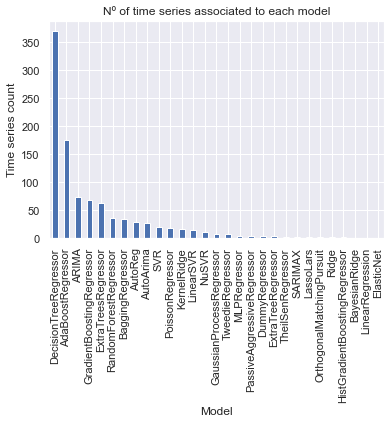

In [16]:
# reloading key-model map with default parameters
keys_models = json.load(open('models/key_model_maps/key_model_map_default.json', 'r'))

# Count how many time series are associated to each model
model_importance = pd.Series(list(keys_models.values())).value_counts()

# Plotting time series count
model_importance.plot.bar()
plt.title('Nº of time series associated to each model')
plt.xlabel('Model'); plt.ylabel('Time series count'); plt.show()

### Scoring default parameters model

In [26]:
# reload model prediction
yhat_i = load_csv_folder('evaluation/predictions/custom models/key_model_map_default/')
eval_criteria = 'wape'
avg=False

# score model predictions by product
prod_scrs = score_prediction_sequences(
    yhat_i, data, prodtype_indexes, target,
    n, test_size, eval_criteria, avg,
    metrics
)

#### Average wape of last 10 two consecutive years by product type (temporary, permanent and pasture)

In [28]:
prod_scrs.mean(1).iloc[-10:].mean()

0.15188260008454413

#### Average wape deviance of last 10 two consecutive years by product type (temporary, permanent and pasture)

In [30]:
prod_scrs.mean(1).iloc[-10:].std()

0.020143858032499334

### Predicting with key-model map generated with default parameters

##### Prediction with key models (for every year pair with at least one value for testing and at least train_min=3 values in the preceding years).

In [21]:
# max size of series
n=44
# Size of consecutive testing samples to forecast
test_size = 2
# Minimun training size when forecasting 
min_train_size = 3
# minimum number of non empty values to score consecutive testing samples
min_test_size=1
# drop na values from prediction
dropna=True

In [ ]:
# Inputing prediction parameters and saving predictions locally
map_models_predictions = maps_predictions(
    lab_ind_series, n, test_size, min_train_size,
    min_test_size, dropna, path='models/key_model_maps/', save=True, # change 'min_test_size' to zero and 'dropna' to False to predict non-included test_samples (when n > n_max)
    save_path='evaluation/predictions/custom models/'
)

### Scoring default parameters model predictions

In [22]:
# metric to calculate
eval_criteria = 'wape'
# wether to average consecutive testing samples scores
avg=False

# Scoring consecutive samples predictions
custom_models_scrs = score_final_models(
    data, prodtype_indexes, target, n,
    test_size, eval_criteria, avg, metrics,
    preds_path='evaluation/predictions/custom models/'
)

### Visualizing model selection performance for default and min_train_size=3 parameters

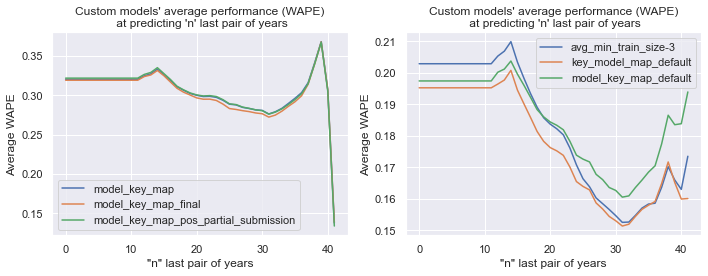

In [23]:
models_keys = pd.Series(list(custom_models_scrs.keys()))

fig = plt.figure(figsize=(10, 4), tight_layout=True)
axes = fig.subplots(1, 2)
n_max = 50
avg_scrs_top = []
avg_scrs_bottom = []

for n_last_pred in list(range(0, n_max)):
    avg_scrs_top.append({key: custom_models_scrs[key].mean(1).iloc[n_last_pred:].mean() for key in models_keys[[2, 4, 5]]})
    avg_scrs_bottom.append({key: custom_models_scrs[key].mean(1).iloc[n_last_pred:].mean() for key in models_keys[[0, 1, 3]]})

pd.DataFrame(avg_scrs_top).plot(ax=axes[0])
pd.DataFrame(avg_scrs_bottom).plot(ax=axes[1])
axes[0].set(
    title="Custom models' average performance (WAPE)\n at predicting 'n' last pair of years",
    ylabel='Average WAPE',
    xlabel='"n" last pair of years'
)
axes[1].set(
    title="Custom models' average performance (WAPE)\n at predicting 'n' last pair of years",
    ylabel='Average WAPE',
    xlabel='"n" last pair of years'
)
plt.show()

#### Conclusions:
    * Default parameters presented the smallest average wape error error for any "n" last pairs of testing values, compared to the other results of model selection for the second set of paramters.
    Obs: The chart in the left shows the average wape for any 'n' consecutive last pais of testing values for models used in the partial submission. It is noticiable that the error drops fast for the predictino of the last pair of values (2016 and 2017) but performance drops for other years (overfitted to 2016 and 2017)

---

# Building submission table

### Predicting with selected key-model map

In [37]:
# Builds submission table based on give model predictions 'yhat'
def build_submission_table(yhat, keys, prodtype_map, years=['2018-01-01', '2019-01-01']):
    df_values = []
    cnt = 0
    for key in keys:
        info = key.split('-')
        city_code = info[0]
        product = info[1]
        if len(info) == 3:
            prodtype=info[2]
        else:
            prodtype = prodtype_map[product]
        for year in years:
            df_values.append([year, city_code, product, prodtype, yhat.iloc[cnt]]); cnt+=1
    return pd.DataFrame(df_values, columns=['year', 'city_code', 'product', 'product_type', 'destinated_area'])

In [44]:
# Loads default paramodel 
def final_submission(model_path, pred_path, pred_index, prodtype_map, years=['2018-01-01', '2019-01-01'], save_path=None):
    key_model_map_default = json.load(open(model_path, 'r'))
    map_keys = list(key_model_map_default.keys())
    yhat_i = load_csv_folder(pred_path)
    yhat = yhat_i[pred_index]
    submission = build_submission_table(yhat, map_keys, prodtype_map, years)
    if save_path is not None:
        submission.to_csv(save_path, index=True)
    return submission

### Saving predictions including future predcitions (2018 and 2019 predictions)

In [ ]:
n=46
test_size=2
min_train_size=1
min_test_size=0
dropna=False
map_models_predictions = maps_predictions(
    lab_ind_series, n, test_size, min_train_size,
    min_test_size, dropna, path='models/key_model_maps/', save=True, # change 'min_test_size' to zero and 'dropna' to False to predict non-included test_samples (when n > n_max)
    save_path='evaluation/future predictions/'
)

### Reloading prediction and building submission table for 2018 and 2019

### Building final submission table

In [45]:
model_path = 'models/key_model_maps/key_model_map_default.json'
pred_path = 'evaluation/future predictions/key_model_map_default/'
pred_index = 44
prodtype_map = dict(data.groupby(['product', 'product_type']).max().index)
years = ['2018-01-01', '2019-01-01']
save_path = 'submission/final_submission.csv'

In [46]:
submission = final_submission(model_path, pred_path, pred_index, prodtype_map, years, save_path)

In [47]:
submission.head(3)

,year,city_code,product,product_type,destinated_area
0,2018-01-01,0307883b5d063703,Cassava,temporary,116.300000
1,2019-01-01,0307883b5d063703,Cassava,temporary,116.300000
2,2018-01-01,0307883b5d063703,Livestock,pasture,8384.741529
